In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene, ttest_ind
from scipy import stats
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy.stats import spearmanr

In [2]:
# Setting the random seed
np.random.seed(14276662)
random.seed(14276662)

## Data Pre-processing

In [3]:
df_spotify = pd.read_csv('data/spotify52kData.csv')
df_ratings = pd.read_csv('data/starRatings.csv',header=None)
df_ratings.columns = df_spotify['track_name'].iloc[:5000] # manually specifying the index to be 5000 song names

In [4]:
# Checking for missing values and the data types of each column
missing_values = df_spotify.isnull().sum()
data_types = df_spotify.dtypes
# Overview of the dataset statistics
dataset_statistics = df_spotify.describe(include='all')

missing_values, data_types, dataset_statistics # data set overall is robust

(songNumber          0
 artists             0
 album_name          0
 track_name          0
 popularity          0
 duration            0
 explicit            0
 danceability        0
 energy              0
 key                 0
 loudness            0
 mode                0
 speechiness         0
 acousticness        0
 instrumentalness    0
 liveness            0
 valence             0
 tempo               0
 time_signature      0
 track_genre         0
 dtype: int64,
 songNumber            int64
 artists              object
 album_name           object
 track_name           object
 popularity            int64
 duration              int64
 explicit               bool
 danceability        float64
 energy              float64
 key                   int64
 loudness            float64
 mode                  int64
 speechiness         float64
 acousticness        float64
 instrumentalness    float64
 liveness            float64
 valence             float64
 tempo               float64
 ti

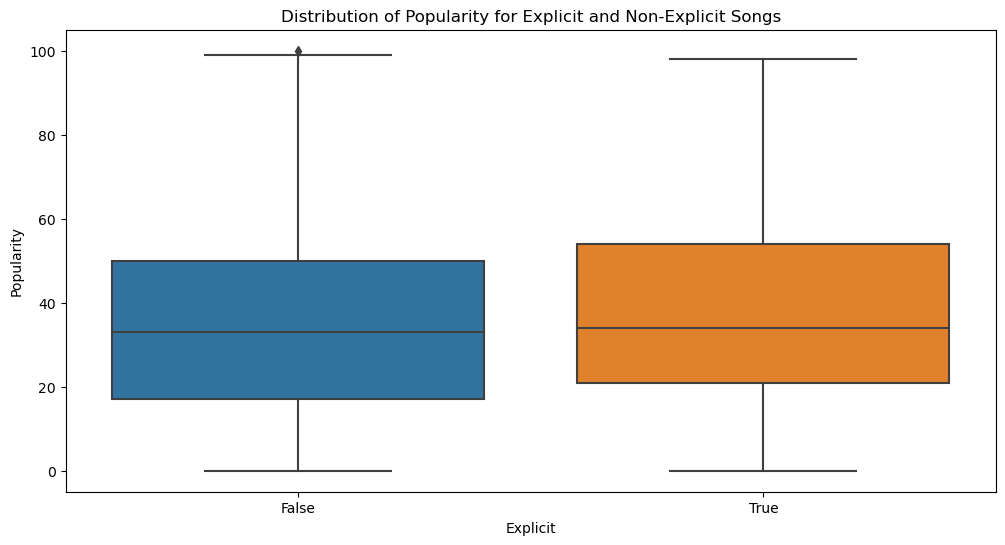

(explicit      0
 popularity    0
 dtype: int64,
 explicit       bool
 popularity    int64
 dtype: object,
 count    5597.000000
 mean       35.813114
 std        22.599548
 min         0.000000
 25%        21.000000
 50%        34.000000
 75%        54.000000
 max        98.000000
 Name: popularity, dtype: float64,
 count    46403.000000
 mean        32.790595
 std         21.615697
 min          0.000000
 25%         17.000000
 50%         33.000000
 75%         50.000000
 max        100.000000
 Name: popularity, dtype: float64)

In [5]:
# Question 2: Are explicitly rated songs more popular than songs that are not explicit? 

# Check for missing values and data types in relevant columns
missing_values = df_spotify[['explicit', 'popularity']].isnull().sum()
data_types = df_spotify[['explicit', 'popularity']].dtypes

# Descriptive statistics for both groups
desc_stats_explicit = df_spotify[df_spotify['explicit'] == True]['popularity'].describe()
desc_stats_non_explicit = df_spotify[df_spotify['explicit'] == False]['popularity'].describe()


plt.figure(figsize=(12, 6))
sns.boxplot(x='explicit', y='popularity', data=df_spotify)
plt.title('Distribution of Popularity for Explicit and Non-Explicit Songs')
plt.xlabel('Explicit')
plt.ylabel('Popularity')
plt.show()

missing_values, data_types, desc_stats_explicit, desc_stats_non_explicit

In [6]:
popularity_explicit = df_spotify[df_spotify['explicit'] == True]['popularity']
popularity_non_explicit = df_spotify[df_spotify['explicit'] == False]['popularity']

# Levene's Test for Homogeneity of variances
levene_test_q2 = levene(popularity_explicit, popularity_non_explicit)
print(f"Q2 levene-test result: {levene_test_q2}") 

# Perform Welch's t-test
t_test_result = ttest_ind(popularity_explicit, popularity_non_explicit, equal_var=False)
print(f"\nQ2 t-test result: {t_test_result}")

Q2 levene-test result: LeveneResult(statistic=16.619770656885425, pvalue=4.574027876730567e-05)

Q2 t-test result: TtestResult(statistic=9.495507012337615, pvalue=2.9549869188182215e-21, df=6888.98867996065)


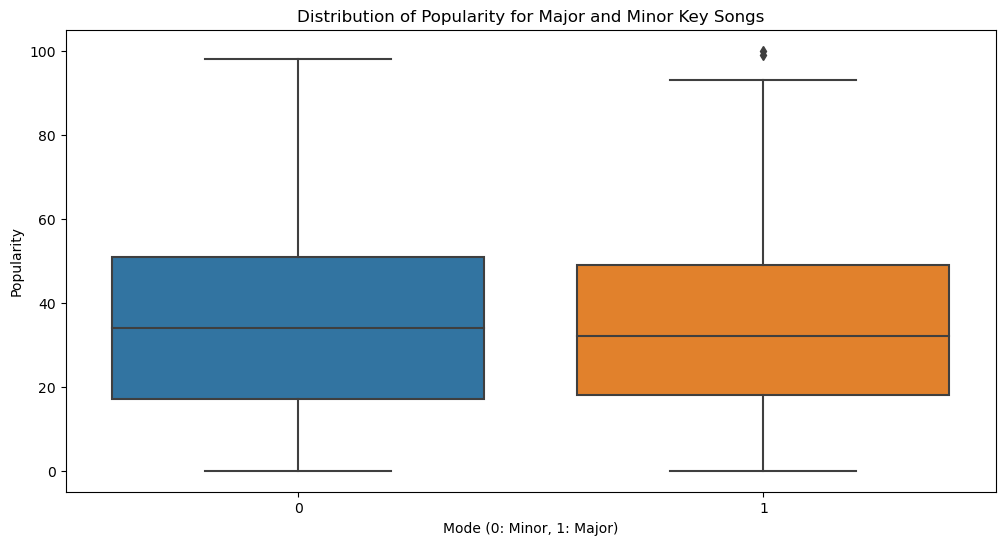

In [7]:
# Question 3: Are songs in major key more popular than songs in minor key?

# Visualize the distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='mode', y='popularity', data=df_spotify)
plt.title('Distribution of Popularity for Major and Minor Key Songs')
plt.xlabel('Mode (0: Minor, 1: Major)')
plt.ylabel('Popularity')
plt.show()

In [8]:
# Levene's test
popularity_major = df_spotify[df_spotify['mode'] == 1]['popularity']
popularity_minor = df_spotify[df_spotify['mode'] == 0]['popularity']
levene_test_q3 = levene(popularity_major, popularity_minor)

print(f"Q3 levene-test result: {levene_test_q3}")

# Perform Welch's t-test again after re-importing necessary library
t_test_result = ttest_ind(popularity_major, popularity_minor, equal_var=False, alternative = 'greater')
print(f"\nQ3 t-test result: {t_test_result}")


Q3 levene-test result: LeveneResult(statistic=51.74085604299448, pvalue=6.418259775893402e-13)

Q3 t-test result: TtestResult(statistic=-4.791517372121929, pvalue=0.9999991694543472, df=40576.19476627967)


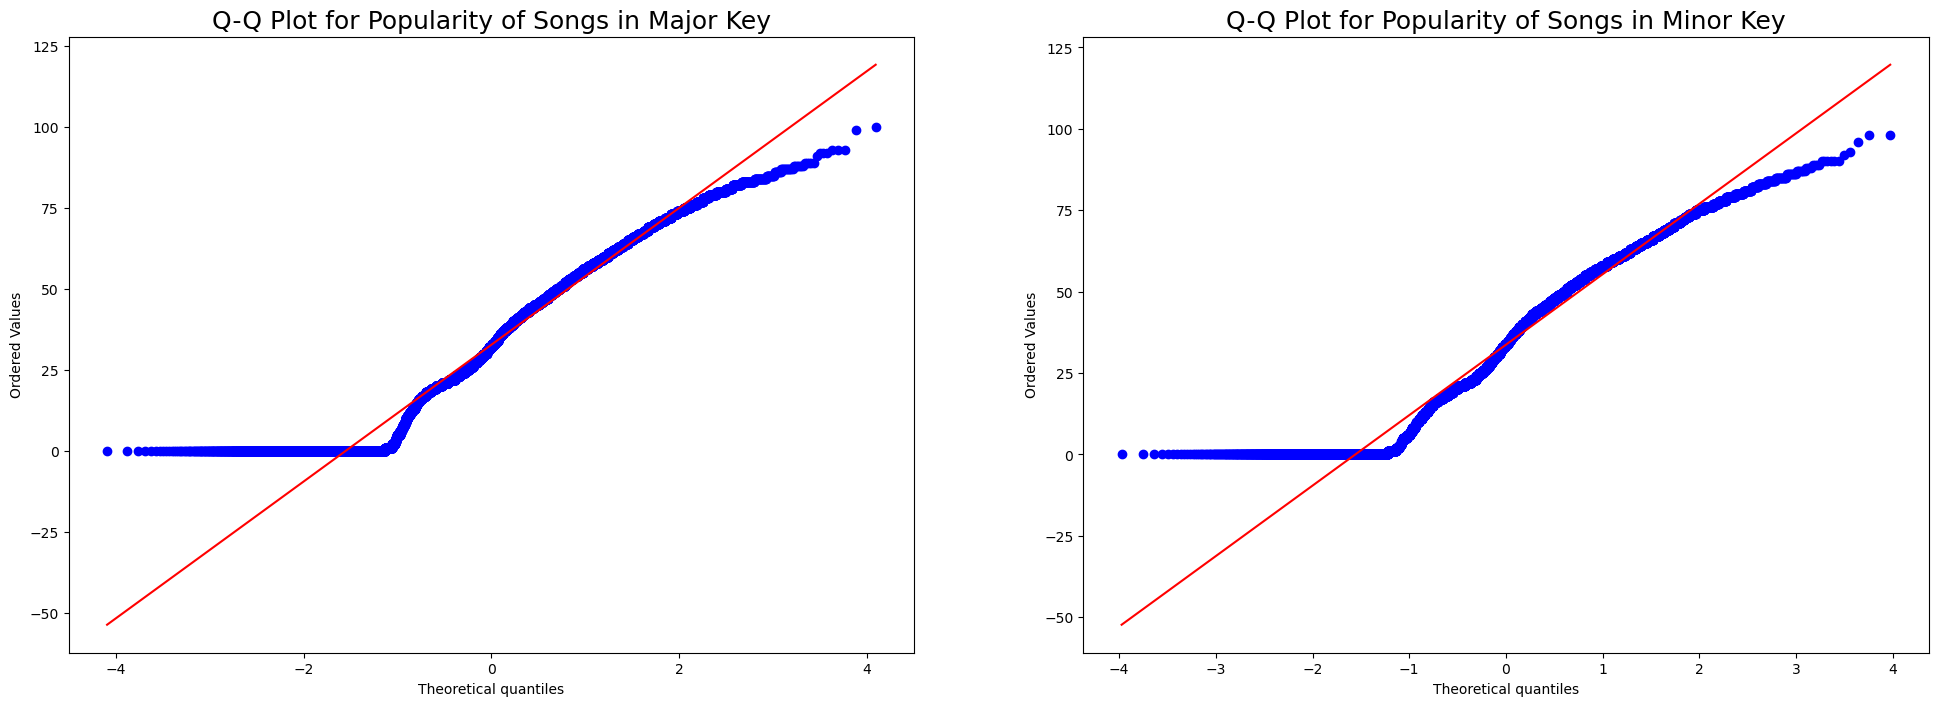

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8)) 

# Q-Q plot for songs in major key
stats.probplot(popularity_major, dist="norm", plot=ax1)
ax1.set_title("Q-Q Plot for Popularity of Songs in Major Key", fontsize = 18)

# Q-Q plot for songs in minor key
stats.probplot(popularity_minor, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot for Popularity of Songs in Minor Key", fontsize = 18)
plt.show()


classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3954
           1       0.62      1.00      0.77      6446

    accuracy                           0.62     10400
   macro avg       0.31      0.50      0.38     10400
weighted avg       0.38      0.62      0.47     10400



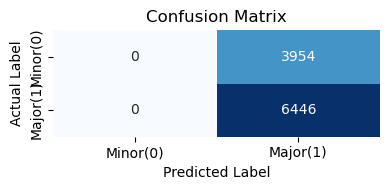

In [10]:
# Question 7: Can you predict whether a song is in major or minor key from valence using logistic regression or a support vector machine? If so, how good is this prediction? If not, is there a better one?

# Setting the random seed
np.random.seed(14276662)
random.seed(14276662)

X = df_spotify[['valence']]
y = df_spotify['mode']       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14276662)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluating
report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'classification report: \n {report}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [11]:
# Check the balance of the classes (major vs. minor keys)
class_balance = df_spotify['mode'].value_counts(normalize=True)
print(f"class balance is: \n{class_balance}")

class balance is: 
mode
1    0.622904
0    0.377096
Name: proportion, dtype: float64


(balanced) classification report: 
               precision    recall  f1-score   support

           0       0.49      0.56      0.52      3871
           1       0.50      0.42      0.46      3973

    accuracy                           0.49      7844
   macro avg       0.49      0.49      0.49      7844
weighted avg       0.49      0.49      0.49      7844



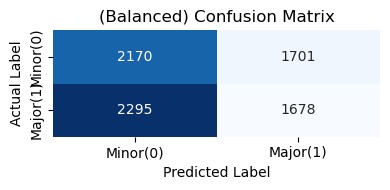

In [12]:

major_key_songs = df_spotify[df_spotify['mode'] == 1]
minor_key_songs = df_spotify[df_spotify['mode'] == 0]

# Under-sampling the major key songs
major_key_songs_sampled = major_key_songs.sample(n=len(minor_key_songs), random_state=14276662)
balanced_df = pd.concat([major_key_songs_sampled, minor_key_songs])
balanced_df = shuffle(balanced_df, random_state=14276662)
X_balanced = balanced_df[['valence']]
y_balanced = balanced_df['mode']


X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=14276662)

log_reg_balanced = LogisticRegression()
log_reg_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = log_reg_balanced.predict(X_test_balanced)

# Evaluating
accuracy_balanced = np.mean(y_test_balanced == y_pred_balanced)
report_balanced = classification_report(y_test_balanced, y_pred_balanced)
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)



print(f'(balanced) classification report: \n {report_balanced}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('(Balanced) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

(balanced) random forest report: 
               precision    recall  f1-score   support

           0       0.52      0.52      0.52      3871
           1       0.54      0.54      0.54      3973

    accuracy                           0.53      7844
   macro avg       0.53      0.53      0.53      7844
weighted avg       0.53      0.53      0.53      7844



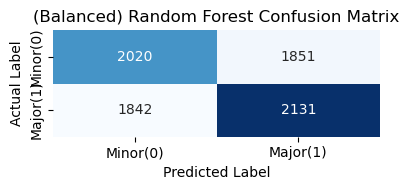

In [13]:
# random forest on balanced dataset
scaler_balanced = StandardScaler()
X_train_balanced_scaled = scaler_balanced.fit_transform(X_train_balanced)
X_test_balanced_scaled = scaler_balanced.transform(X_test_balanced)
rf_balanced = RandomForestClassifier(random_state=14276662)
rf_balanced.fit(X_train_balanced_scaled, y_train_balanced)

y_pred_rf_balanced = rf_balanced.predict(X_test_balanced_scaled)

# Evaluating
accuracy_rf_balanced = rf_balanced.score(X_test_balanced_scaled, y_test_balanced)
conf_matrix_rf_balanced = confusion_matrix(y_test_balanced, y_pred_rf_balanced)
class_report_rf_balanced = classification_report(y_test_balanced, y_pred_rf_balanced)

print(f'(balanced) random forest report: \n {class_report_rf_balanced}')
# Plotting the confusion matrix
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix_rf_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=['Minor(0)', 'Major(1)'], yticklabels=['Minor(0)', 'Major(1)'],cbar=False)
plt.title('(Balanced) Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

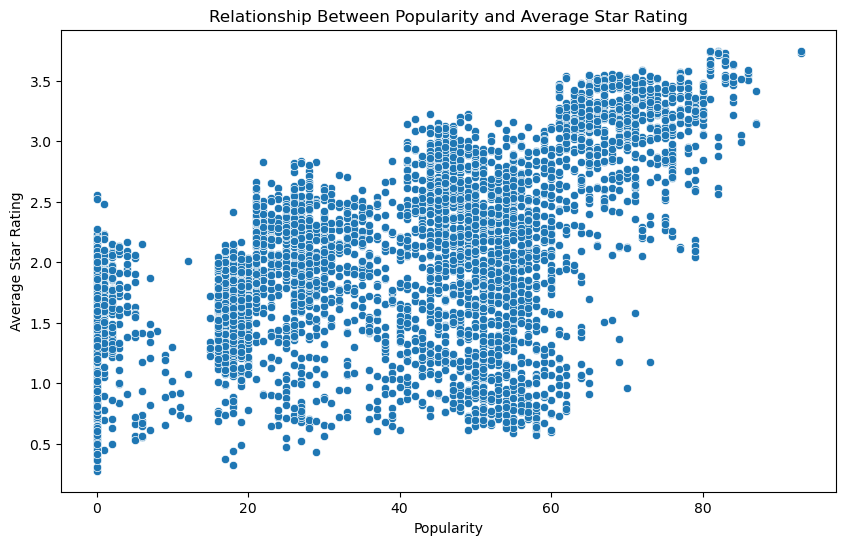

Spearman's rank correlation between popularity and average star rating is 0.543458638456252, with a p-value of 0.0


In [14]:
# Question 9: In recommender systems, the popularity based model is an important baseline. We have a two part question in this regard: a) Is there a relationship between popularity and average star rating for the 5k songs we have explicit feedback for? b) Which 10 songs are in the “greatest hits” (out of the 5k songs), on the basis of the popularity based model?
# Q9a
average_ratings = df_ratings.mean(axis=0)
df_spotify['average_rating'] = np.nan
df_spotify.loc[:4999, 'average_rating'] = average_ratings.values

plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='average_rating', data=df_spotify)
plt.title('Relationship Between Popularity and Average Star Rating')
plt.xlabel('Popularity')
plt.ylabel('Average Star Rating')
plt.show()


# Spearman's rank correlation test
spearman_corr, spearman_p_value = spearmanr(df_spotify['popularity'][:5000], df_spotify['average_rating'][:5000])
spearman_corr, spearman_p_value
print(f"Spearman's rank correlation between popularity and average star rating is {spearman_corr}, with a p-value of {spearman_p_value}")

In [15]:
X_ols = df_spotify[['popularity']][:5000]  
y_ols = df_spotify['average_rating'][:5000]
X_ols = sm.add_constant(X_ols)

# OLS model
ols_model = sm.OLS(y_ols, X_ols).fit()
ols_summary = ols_model.summary()
ols_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         average_rating   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     2398.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:10:16   Log-Likelihood:                -4472.1
No. Observations:                5000   AIC:                             8948.
Df Residuals:                    4998   BIC:                             8961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4355      0.014    101.578      0.000       1.408       1.463
popularity     0.0165      0.000     48.967      0.000       0.016       0.017
==============================================================================
Omnibus:                      415.574   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              526.689
Skew:                          -0.794   Prob(JB):                    4.28e-115
Kurtosis:                       3.086   Cond. No.                         71.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Q9b
sorted_songs = df_spotify[:5000].sort_values(by='average_rating', ascending=False)
top_10_songs = sorted_songs.head(10)
top_10_songs_details = top_10_songs[['artists', 'track_name', 'album_name', 'average_rating','popularity','track_genre']]
top_10_songs_details

,artists,track_name,album_name,average_rating,popularity,track_genre
3877,The Offspring,"You're Gonna Go Far, Kid","Rise And Fall, Rage And Grace",3.750000,81,alternative
3003,The Neighbourhood,Sweater Weather,I Love You.,3.748950,93,alternative
2260,Red Hot Chili Peppers,Can't Stop,By the Way (Deluxe Edition),3.744554,82,alt-rock
2562,The Offspring,"You're Gonna Go Far, Kid","Rise And Fall, Rage And Grace",3.743202,81,alt-rock
3216,Red Hot Chili Peppers,Californication,Californication (Deluxe Edition),3.741969,82,alternative
2105,Red Hot Chili Peppers,Californication,Californication (Deluxe Edition),3.737475,82,alt-rock
2003,The Neighbourhood,Sweater Weather,I Love You.,3.729651,93,alt-rock
2011,WALK THE MOON,Shut Up and Dance,TALKING IS HARD,3.729124,83,alt-rock
3464,Red Hot Chili Peppers,Can't Stop,By the Way (Deluxe Edition),3.727829,82,alternative
3253,Gorillaz;Tame Impala;Bootie Brown,New Gold (feat. Tame Impala and Bootie Brown),New Gold (feat. Tame Impala and Bootie Brown),3.727451,82,alternative


In [17]:
# here we explore the repeating entries, with conclusions in our written document

# Finding the rows that are repeated based on both 'track_name' and 'album_name' and 'track_genre'
duplicates = sorted_songs[sorted_songs.duplicated(subset=['track_name', 'album_name','track_genre'], keep=False)]
sorted_duplicates = duplicates.sort_values(by=['track_name', 'album_name','track_genre'])
sorted_duplicates[['songNumber','artists','album_name','track_name','popularity','average_rating']].head()

,songNumber,artists,album_name,track_name,popularity,average_rating
2116,2116,Counting Crows,Alternative Christmas 2022,A Long December,0,1.713858
2168,2168,Counting Crows,Alternative Christmas 2022,A Long December,0,1.681772
3269,3269,Counting Crows,Alternative Christmas 2022,A Long December,0,1.696373
3270,3270,Counting Crows,Alternative Christmas 2022,A Long December,0,1.681729
1001,1001,Criolo,Ainda Há Tempo,Ainda Há Tempo,44,2.557393


### Question 10: You want to create a “personal mixtape” for all 10k users who have explicit feedback for. This mixtape contains individualized recommendations as to the 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [18]:
# Question 10: You want to create a “personal mixtape” for all 10k users who have explicit feedback for. This mixtape contains individualized recommendations as to the 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [19]:
from surprise import Dataset, Reader, SVDpp
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
### The SVD++ code might take 10 minutes to run ###

reader = Reader(rating_scale=(0, 4))  # Assuming ratings are from 0 to 4
data = Dataset.load_from_df(df_ratings.stack().reset_index(name='rating'), reader)
trainset, testset = train_test_split(data, test_size=0.3, random_state = 14276662)


# model = SVDpp(n_factors=10, n_epochs=3, lr_all=0.01)
# model.fit(trainset)
# predictions = model.test(testset)
# accuracy = rmse(predictions) # result: RMSE=1.0704 

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
ratings_matrix = df_ratings.fillna(-1).values

# user-user cosine similarity
user_similarity = cosine_similarity(ratings_matrix)

# predict ratings
def predict_ratings(user_similarity, ratings):
    mean_user_rating = ratings.mean(axis=1)
    ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    return pred
predicted_ratings = predict_ratings(user_similarity, ratings_matrix)

# Generate recommendations
top_n_recommendations = 10
user_recommendations = {}
for user_id in range(predicted_ratings.shape[0]):
    user_unrated_items = np.where(df_ratings.iloc[user_id].isna())[0]
    user_predictions = predicted_ratings[user_id, user_unrated_items]
    top_items_indices = user_predictions.argsort()[-top_n_recommendations:][::-1]
    user_recommendations[user_id] = top_items_indices

In [21]:
# Sample code to calculate Precision and Recall
def calculate_precision_recall(user_recommendations, df_ratings, threshold=3):
    precision_list = []
    recall_list = []

    for user_id, recommended_items in user_recommendations.items():
        # Actual liked items: items rated above the threshold
        actual_liked = set(df_ratings.columns[(df_ratings.iloc[user_id] >= threshold).fillna(False)])

        # Recommended items
        recommended = set(recommended_items)

        # Intersection of liked and recommended items
        relevant_and_recommended = recommended.intersection(actual_liked)

        # Precision and Recall calculations
        precision = len(relevant_and_recommended) / len(recommended) if recommended else 0
        recall = len(relevant_and_recommended) / len(actual_liked) if actual_liked else 0

        precision_list.append(precision)
        recall_list.append(recall)

    # Average Precision and Recall
    average_precision = np.mean(precision_list)
    average_recall = np.mean(recall_list)

    return average_precision, average_recall

average_precision, average_recall = calculate_precision_recall(user_recommendations, df_ratings)
print(f"average recall is: {average_recall}")
print(f"average precision is: {average_precision}")

average recall is: 0.0
average precision is: 0.0


In [22]:
from collections import Counter

all_recommended_songs = [song for recommendations in user_recommendations.values() for song in recommendations]
song_frequency = Counter(all_recommended_songs)
top_10_common_recommendations = [df_spotify.loc[song_id, 'track_name'] for song_id, _ in song_frequency.most_common(10)]
top_10_common_recommendations

["Breezin'",
 'Thank You',
 'Abyssinian Suite, Pt. 4',
 'Mango Cool',
 'Higher Ground - Remastered',
 'Life of Grace',
 'Gracias',
 'A Great Big Sled',
 'Black Summer',
 'sail away']

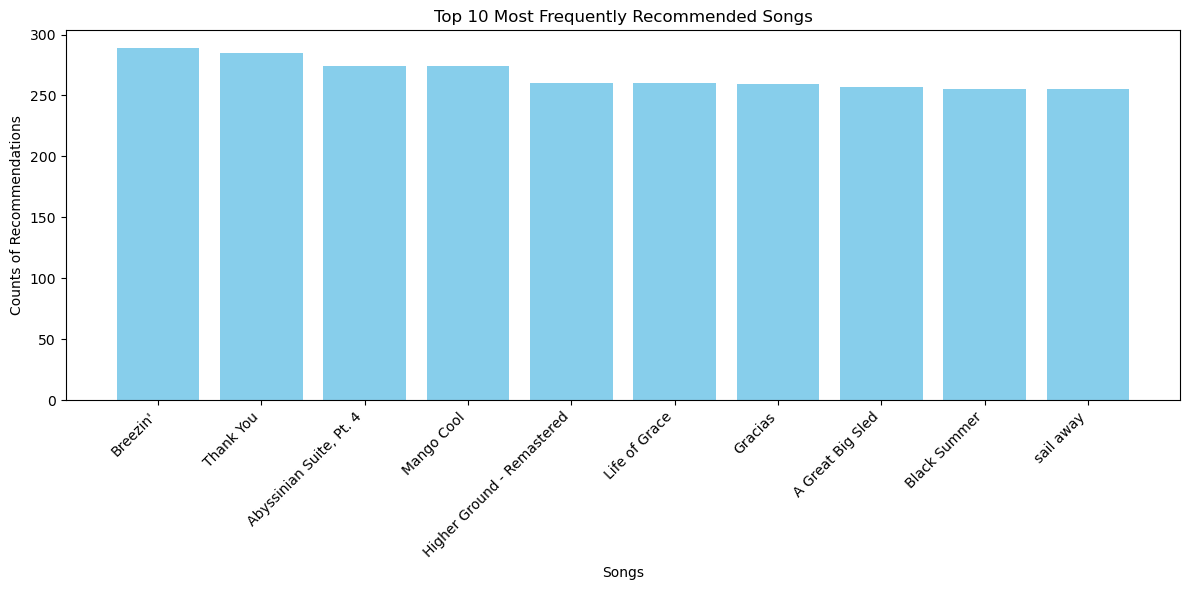

In [23]:
import matplotlib.pyplot as plt
from collections import Counter

top_10_common_recommendations_indices = song_frequency.most_common(10)
top_10_frequencies = [freq for _, freq in top_10_common_recommendations_indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(top_10_common_recommendations, top_10_frequencies, color='skyblue')
plt.xlabel('Songs')
plt.ylabel('Counts of Recommendations')
plt.title('Top 10 Most Frequently Recommended Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

